<a href="https://colab.research.google.com/github/lenust/neuronet_holes_in_leaves/blob/main/Damaged_area_calculation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Connect your Google Drive and specify the paths to the pretrained model and to the folder with damaged leaves for damage area calculation

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

model = "/content/drive/MyDrive/neuronet for damaged area calculation/trained_model.pth" # Replace with the path to your model if necessary
true_test_folder = '/content/drive/MyDrive/neuronet for damaged area calculation/leaves_for_area_calculation' # Replace with the path to your folder if necessary

Install the segmentation-models-pytorch package
Check if a GPU (CUDA) is available, and if so, set the device to CUDA; otherwise, set it to CPU.

In [ ]:
# Install the segmentation-models-pytorch package
!pip install segmentation-models-pytorch

# Clear the IPython output
from IPython.display import clear_output
clear_output()

In [ ]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Check if GPU is available, set the device accordingly

Load the pretrained model state dictionary

In [ ]:
import segmentation_models_pytorch as smp
import torch
import torch.optim as optim
import torch.nn as nn

# Create an instance of the UNet++ model with the specified encoder architecture and one output class
model = smp.UnetPlusPlus(encoder_name="efficientnet-b0", classes = 1)

# Load the pretrained model state dictionary from a file
model.load_state_dict(torch.load(model))

# Move the model to the selected device (CPU or GPU)
model.to(device)

Create dataset with damaged leaves and use neuronet. Display the original damaged leaves and their masks reconstructed by the neural network

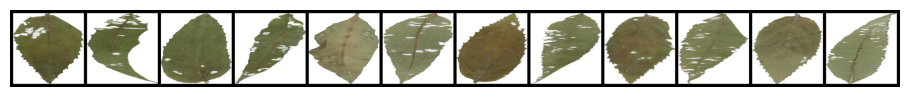

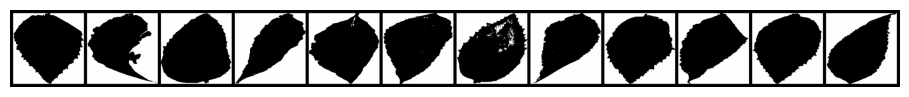

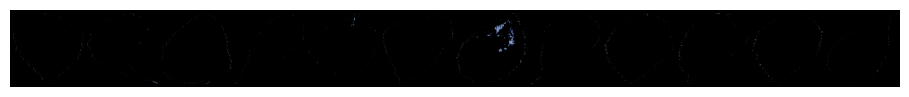

In [ ]:
# Import the necessary libraries and modules
import os
import torch
from PIL import Image
import numpy as np
import torchvision.transforms as transforms
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

# Define a function to load an image from a file path
def load_image(path):
    with open(path, 'rb') as f:
        img = Image.open(f)
        # Apply a series of transformations: convert to tensor and resize to (224, 224)
        return transforms.Compose([transforms.ToTensor(), transforms.Resize((224, 224))])(img)

# Define a custom dataset class
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, folder1):
        self.folder1 = folder1
        # Get a list of filenames in the specified folder
        self.filenames = [f for f in os.listdir(folder1)]

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, index):
        filename = self.filenames[index]
        img1_path = os.path.join(self.folder1, filename)
        img1 = load_image(img1_path)
        return img1

# Create an instance of the custom dataset using the specified folder
true_test = CustomDataset(true_test_folder)

# Define a function to display a grid of images
def show(batch, cols=16):
    cols = min(cols, len(batch))
    img_grid = make_grid(batch[:cols], padding=10, nrow=cols)
    plt.figure(figsize=(cols, 1))
    plt.axis("off")
    plt.imshow(np.transpose(img_grid.numpy(), (1, 2, 0)))

# Define a function to display model predictions on the test dataset
def show_valset_pred(model, cols=16):
    images, pred_masks = [], []
    for batch in true_test:
        with torch.no_grad():
            img = batch
            images.append(img.unsqueeze(0))
            output = model(img.unsqueeze(0).to(device))
            pred_masks.append(output.cpu())
    # Display the original images, predicted masks, and the difference between them
    show(torch.stack(images).squeeze()[:cols, ...])
    show(torch.stack(pred_masks).squeeze(1)[:cols, ...])
    show(torch.stack(pred_masks).squeeze(1)[:cols, ...] - torch.stack(images).squeeze()[:cols, ...]) # ЭТО ПОТОМ УБРАТЬ!!!

# Display the original damaged leaves and their masks reconstructed by the neural network
print("The original damaged leaves and their masks reconstructed by the neural network")
show_valset_pred(model)


Compute the predicted masks for each image in the true_test dataset using the neural network model and stores the images and their corresponding predicted masks in the images and pred_masks lists.

In [ ]:
# Initialize empty lists to store original images and predicted masks
images, pred_masks = [], []

# Iterate through the 'true_test' dataset
for batch in true_test:
    # Disable gradient calculation during inference
    with torch.no_grad():
        # Get an image batch from the dataset
        img = batch
        # Add the image to the 'images' list with an additional dimension (unsqueeze)
        images.append(img.unsqueeze(0))
        # Pass the image through the model to get the predicted mask
        output = model(img.unsqueeze(0).to(device))
        # Append the predicted mask to the 'pred_masks' list after moving it to the CPU
        pred_masks.append(output.cpu())


 Resize the images and predicted masks to match the dimensions of their corresponding original images, ensuring they have the same dimensions for further area calculation

In [ ]:
import os
from PIL import Image

# Initialize an empty list to store image sizes
image_sizes = []

# Iterate through the files in the 'true_test_folder'
for filename in os.listdir(true_test_folder):
    # Check if the file has a '.jpg' or '.png' extension
    if filename.endswith('.jpg') or filename.endswith('.png'):
        # Create the full file path
        filepath = os.path.join(folder, filename)
        # Open the image using PIL (Pillow)
        with Image.open(filepath) as img:
            # Get the size (width, height) of the image and append it to 'image_sizes'
            image_sizes.append(img.size)

# Create a list of image sizes with swapped dimensions (height, width)
image_sizes = [(y, x) for x, y in image_sizes]

# Define a function to resize images to specified sizes using bilinear interpolation
def resize_images(images, sizes):
    resized_images = []
    for img, size in zip(images, sizes):
        # Resize the image using bilinear interpolation
        resized_img = torch.nn.functional.interpolate(img.unsqueeze(0), size=size, mode='bilinear', align_corners=False)
        # Remove the batch dimension and append the resized image to 'resized_images'
        resized_images.append(resized_img.squeeze(0))
    return resized_images

# Resize the original images and predicted masks to match their respective image sizes
resized_images = resize_images(torch.stack(images).squeeze(), image_sizes)
resized_masks = resize_images(torch.stack(pred_masks).squeeze(1), image_sizes)


Substract original images from their masks to get the damaged parts and calculate their area

In [ ]:
import cv2
import numpy as np
import torch

# Define a function to normalize a tensor image
def normalize(img):
    img_min = img.min()
    img_max = img.max()
    return (img - img_min) / (img_max - img_min)

# Define a function to binarize a tensor image
def binarize_image(tensor_image, threshold=128):
    # Normalize the tensor image
    tensor_image = normalize(tensor_image)
    grayscale_image = tensor_image.mean(dim=0, keepdim=True)
    grayscale_image = (grayscale_image * 255).numpy().astype(np.uint8)

    # Apply morphological closing to remove noise and enhance object boundaries
    kernel = np.ones((1, 1), np.uint8)  # Kernel size may need adjustment
    closed_image = cv2.morphologyEx(grayscale_image, cv2.MORPH_CLOSE, kernel)

    # Binarize the closed image using the specified threshold
    binarized_image = (closed_image > threshold).astype(np.uint8)
    return torch.from_numpy(binarized_image).float()

# Define a function to subtract two lists of tensor images
def subtract_tensor_lists(list1, list2):
    result = []
    for t1, t2 in zip(list1, list2):
        # Binarize the tensors and find contours in the binary image
        image = binarize_image(t1).squeeze(0).numpy().astype(np.uint8)
        contours, _ = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        # Create an empty image of the same size as the original image
        contour_image = np.zeros_like(image)

        # Draw the external contour of the object on the empty image
        cv2.drawContours(contour_image, contours, -1, (1, 1, 1), 5)

        # Calculate the difference between two binary images
        subtracted_tensor = contour_image - binarize_image((binarize_image(t2) - binarize_image(t1))).squeeze(0).numpy().astype(np.uint8)

        # Append the result as a binarized tensor
        result.append(binarize_image(torch.from_numpy(subtracted_tensor).unsqueeze(0)))

    return result

# Perform the subtraction operation on a list of images
subtracted_list = subtract_tensor_lists(resized_masks, resized_images)

# Get a list of all files in the 'true_test_folder'
files = os.listdir(true_test_folder)

# Calculate the area of objects in the resulting images and print the filename and area
for i, filename in enumerate(files):
    tensor = subtracted_list[i]
    square = torch.sum(tensor).item()
    print(f"File: {filename}, Object Area: {square}")

Этот кусок выкинуть, если следующий норм работает

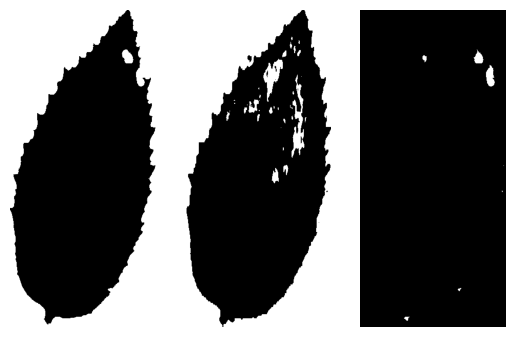

In [ ]:
print("The original damaged leaves, their masks reconstructed by the neural network and the result of their subtraction (damaged areas)")

fig, axes = plt.subplots(1, 3)
axes[0].imshow(binarize_image(resized_images[6]).permute(1,2,0), cmap="gray")
axes[1].imshow(binarize_image(resized_masks[6]).permute(1,2,0), cmap="gray")
axes[2].imshow(subtracted_list[6].squeeze(0), cmap='gray')
axes[0].axis('off')  # Отключите оси координат
axes[1].axis('off')
axes[2].axis('off')
plt.show()

Show the original damaged leaves, masks reconstructed by the neural network, and the result of subtracting the masks from the original images

In [ ]:
# Print a title indicating the purpose of the images
print("The original damaged leaves, their masks reconstructed by the neural network and the result of their subtraction (damaged areas)")

# Define a function to display a grid of images with a specified title
def show_images(images, title):
    num_images = len(images)
    rows = 1  # Number of rows in the grid (set to 1 for horizontal display)
    cols = min(num_images, 10)  # Number of columns in the grid (up to 10 columns)

    # Create a grid of images using make_grid
    img_grid = make_grid(images[:cols], nrow=cols)

    # Create a figure for displaying the grid
    plt.figure(figsize=(cols, rows))

    # Turn off axis labels
    plt.axis("off")

    # Set the title for the figure
    plt.title(title)

    # Display the grid of images
    plt.imshow(np.transpose(img_grid.numpy(), (1, 2, 0)))

    # Show the figure
    plt.show()

# Display the three sets of images with their respective titles
show_images(resized_images, "damaged leaves")
show_images(resized_masks, "masks reconstructed by the neural network")
show_images(subtracted_list, "damaged areas")
